In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath("../Notebooks"))
from helper_functions import  *
from tqdm import tqdm

# Import Data

In [32]:
# Read compressed csv with built-in gzip support
df_recipes = decompress_pickle('../Data/file4.pbz2') 
df_ingredients = pd.read_csv('../Data/ingredients_with_recipies.csv')
df_reviews = decompress_pickle('../Data/reviews_zipped.pbz2') 

In [33]:
df_recipes.head()

,name,id,minutes,ingredients,n_ingredients,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,"[winter squash, mexican seasoning, mixed spice...",7,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,"[spreadable cheese with garlic and herbs, new ...",11,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,"[milk, vanilla ice cream, frozen apple juice c...",4,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,"[fennel seeds, green olives, ripe olives, garl...",9,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."


In [82]:
df_recipes.shape

(178265, 6)

In [34]:
df_ingredients.head()

,Unnamed: 0,raw_ingr,raw_words,processed,len_proc,replaced,count,id,recipes
0,0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
1,1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
2,2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
3,3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
4,4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."


In [35]:
df_reviews.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [53]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

In [54]:
df_reviews.dtypes

user_id               int64
recipe_id             int64
date         datetime64[ns]
rating                int64
review               object
dtype: object

In [68]:
# 1998 :) 

df_reviews = df_reviews[df_reviews['date'].dt.strftime('%Y') > '1998']
df_reviews

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
9995,862526,101583,2010-02-17,5,Excellent! I used red bell peppers and added ...
9996,2000366379,101583,2015-07-27,0,"Carol, came out great! It was easy and fun to ..."
9997,199848,145677,2010-04-21,5,"Just as decribed.... spicy (but not too much),..."
9998,2666773,145677,2013-01-30,5,Spicy and Healthy? Perfect combination. I per...


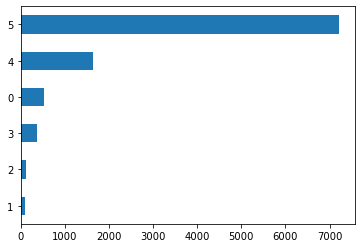

In [69]:
df_reviews.rating.value_counts().sort_values().plot(kind = 'barh')
None

In [70]:
df_reviews.shape

(10000, 5)

# Create edges

In [71]:
from tqdm import tqdm
#Define a dictionary for every ingredient with a list of recipes


ing_dict = { id: [] for id in df_ingredients['id'].unique()} #as we are not taking all of the recipes some list will be empty at the end


for idx, row in tqdm(df_recipes.iterrows()): 
    #
    for ingredient in row['ingredient_ids']:
        ing_dict[ingredient].append(row['id'])

72186it [00:06, 10688.38it/s]


KeyboardInterrupt: 

In [8]:
#Needs to be finished
from itertools import combinations
    
edges = [(x,y, {"ingredient": key})  for key in ing_dict for x, y in list(combinations(ing_dict[key], 2))]   

# All possible pairs in List
# Using combinations()


In [72]:
recipes_user_dict={id: [] for id in df_recipes['id'].unique()}
print(len(recipes_user_dict))
recipe_error = []


for idx, row in tqdm(df_reviews.iterrows()): 
    try:
        #for ingredient in row['ingredient_ids']:
        recipes_user_dict[row['recipe_id']].append(row['user_id'])
    except:
        recipe_error.append(row['recipe_id'])


#Needs to be finished
from itertools import combinations
    
edges_ru = [(x,y, {"recipe_id": key})  for key in recipes_user_dict for x, y in list(combinations(recipes_user_dict[key], 2))]   

# All possible pairs in List
# Using combinations()


178265


10000it [00:00, 21205.08it/s]


In [ ]:
recipes_user_dict

## Create Graph

In [39]:
#!pip install networkx
import networkx as nx

G = nx.MultiDiGraph()
G.add_nodes_from(df_recipes['id'].values, name=df_recipes['name'].values, n_ingredients=df_recipes['n_ingredients'].values)
print(G)

G.add_edges_from(edges)
print(G)

MultiDiGraph with 178265 nodes and 0 edges


NameError: name 'edges' is not defined

In [73]:
#!pip install networkx
import networkx as nx

G = nx.MultiDiGraph()
G.add_nodes_from(np.unique(df_reviews['user_id'].values))
print(G)

G.add_edges_from(edges_ru)
print(G)

MultiDiGraph with 6451 nodes and 0 edges
MultiDiGraph with 6451 nodes and 162363 edges


# Graph analysis

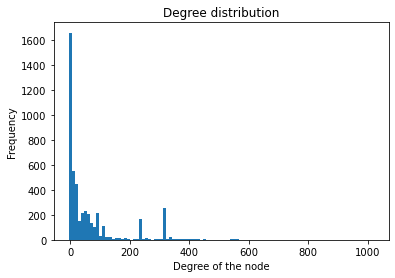

Slope of distribution: -0.5572515807168604


In [86]:

# In and out degree distributions & slope estimate(W5)
def plot_deg_dist(G, title = str):

    degree_list = [val for (node, val) in G.degree() if val != 0]

    counts, edges = np.histogram(degree_list, bins = 100)
    plt.bar(edges[:-1], counts, width=np.diff(edges))
    plt.title(title)
    plt.xlabel('Degree of the node')
    plt.ylabel('Frequency')
    plt.show()
    idx = np.isfinite(np.log(edges[:10])) & np.isfinite(np.log(counts[:10]))
    slope, intercept = np.polyfit(np.log(edges[:10])[idx], np.log(counts[:10])[idx], 1)
    print(f'Slope of distribution: {slope}')

plot_deg_dist(G, title = 'Degree distribution')  
    

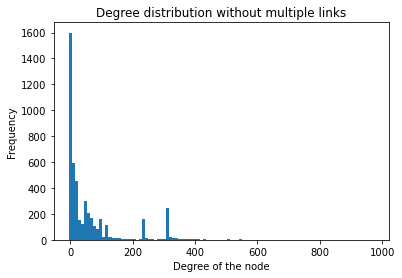

Slope of distribution: -0.6086021528044925


In [87]:
G2 = nx.Graph(G)
plot_deg_dist(G2, title = 'Degree distribution without multiple links')  

In [88]:
largest_cc = max(nx.connected_components(G2))
GCC = G2.subgraph(largest_cc).copy()

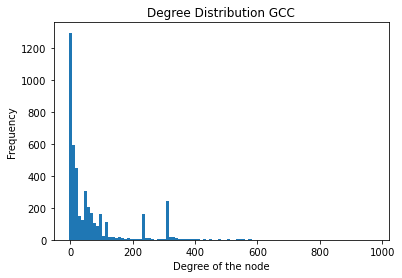

Slope of distribution: -0.5656609495304976


In [90]:
plot_deg_dist(GCC, title = 'Degree Distribution GCC')

In [84]:
from statistics import mean
from scipy import stats

degree_list = [val for (node, val) in GCC.degree()]
# Calculate stats
mean = np.mean(degree_list)
median = np.median(degree_list)
mode = stats.mode(degree_list)[0]
d_min = np.min(degree_list)
d_max = np.max(degree_list)

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 72.3234501347709
Median:27.0
Mode:[321]
Min:1
Max:976


/var/folders/0l/b401ys7x3v303b2m4jkcr32r0000gn/T/ipykernel_22222/574384640.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(degree_list)[0]


# Plot Graph with Force Atlas

In [78]:
%%capture
!pip install fa2

100%|██████████| 2000/2000 [01:49<00:00, 18.21it/s]


BarnesHut Approximation  took  51.09  seconds
Repulsion forces  took  42.17  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  12.38  seconds
AdjustSpeedAndApplyForces step  took  1.99  seconds


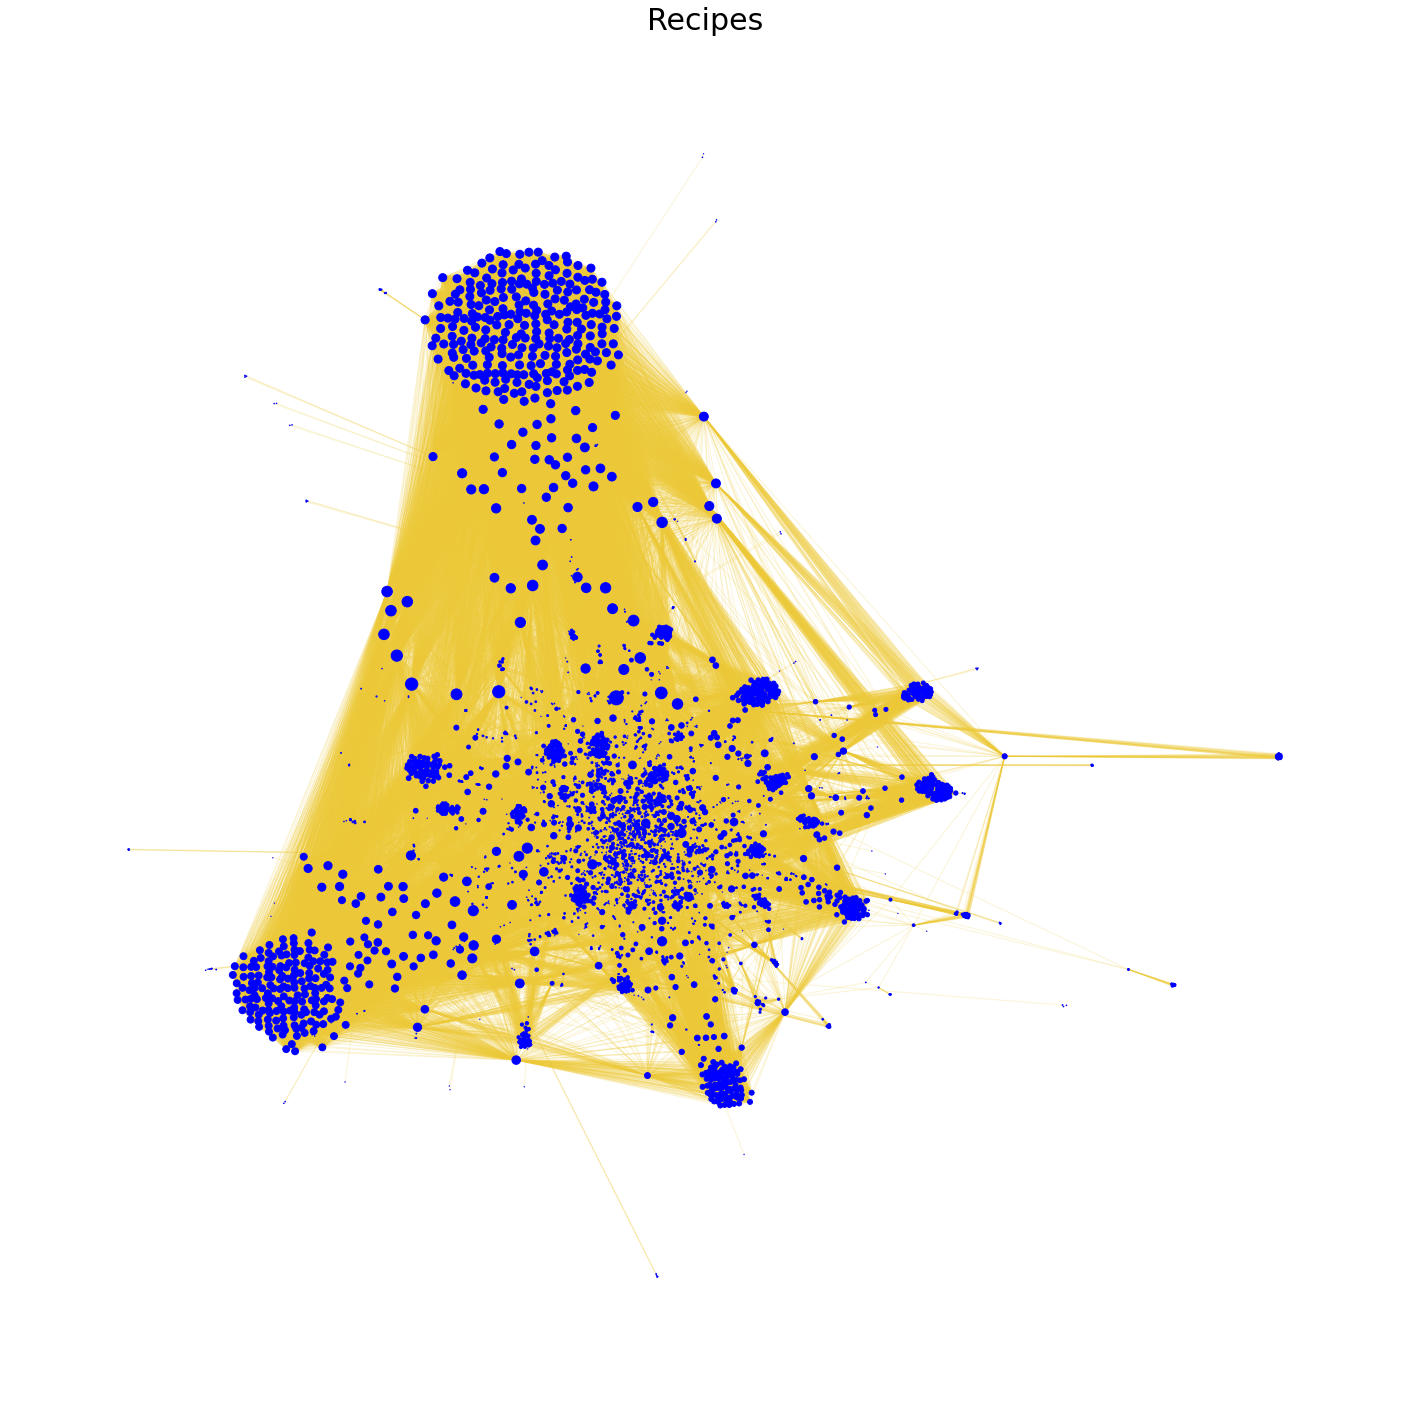

In [81]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from itertools import count
# Plot network using Force Atlas algorithm

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)



# Gets positions of the nodes 
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=2000)

# Node size dictionary according to degrees
d = dict(nx.degree(GCC))

# Create color mapping dictionary
#mapping = {"Marvel": 'red', "DC": 'black'}
#colors = [mapping[GCC_U.nodes[n]['universe']] for n in GCC_U.nodes()]



# Plot the Network 
plt.figure(3,figsize=(25,25)) 
nc = nx.draw_networkx_nodes(GCC, 
                       positions, 
                       node_size=[v * 0.2 for v in d.values()], 
                       #node_size = 10,
                       label=True,  
                       node_color='blue',
                       #cmap=plt.cm.plasma_r, 
                       )

ec = nx.draw_networkx_edges(GCC, 
                            positions, 
                            edge_color="#ECC836", 
                            alpha=0.2)

plt.axis('off')
plt.title('Recipes', size = 30)
plt.show()

100%|██████████| 2000/2000 [02:34<00:00, 12.98it/s]


BarnesHut Approximation  took  43.14  seconds
Repulsion forces  took  18.06  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  87.70  seconds
AdjustSpeedAndApplyForces step  took  1.69  seconds


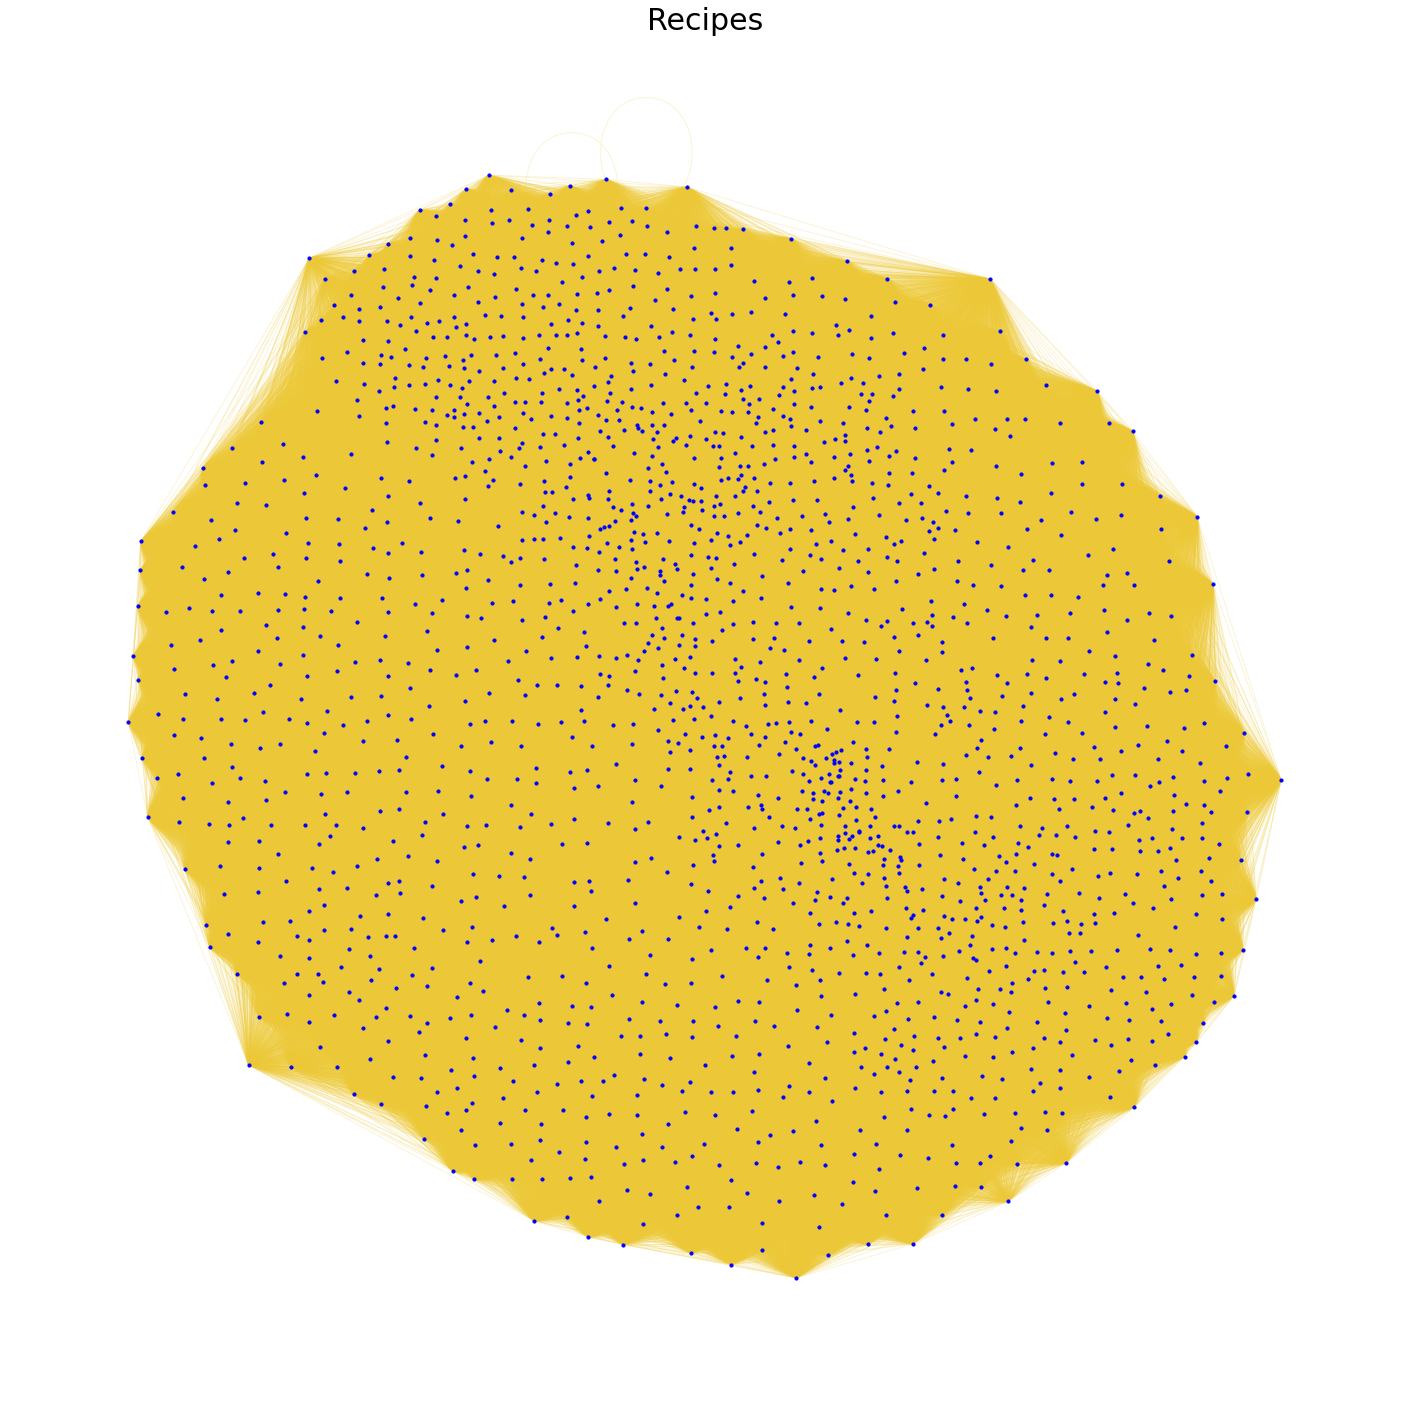

In [29]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from itertools import count
# Plot network using Force Atlas algorithm

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)



# Gets positions of the nodes 
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=2000)

# Node size dictionary according to degrees
d = dict(nx.degree(GCC))

# Create color mapping dictionary
#mapping = {"Marvel": 'red', "DC": 'black'}
#colors = [mapping[GCC_U.nodes[n]['universe']] for n in GCC_U.nodes()]



# Plot the Network 
plt.figure(3,figsize=(25,25)) 
nc = nx.draw_networkx_nodes(GCC, 
                       positions, 
                       #node_size=[v * 2 for v in d.values()], 
                       node_size = 10,
                       label=True,  
                       node_color='blue',
                       #cmap=plt.cm.plasma_r, 
                       )

ec = nx.draw_networkx_edges(GCC, 
                            positions, 
                            edge_color="#ECC836", 
                            alpha=0.2)

plt.axis('off')
plt.title('Recipes', size = 30)
plt.show()


100%|██████████| 2000/2000 [02:41<00:00, 12.37it/s]


BarnesHut Approximation  took  42.79  seconds
Repulsion forces  took  19.44  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  93.90  seconds
AdjustSpeedAndApplyForces step  took  1.78  seconds


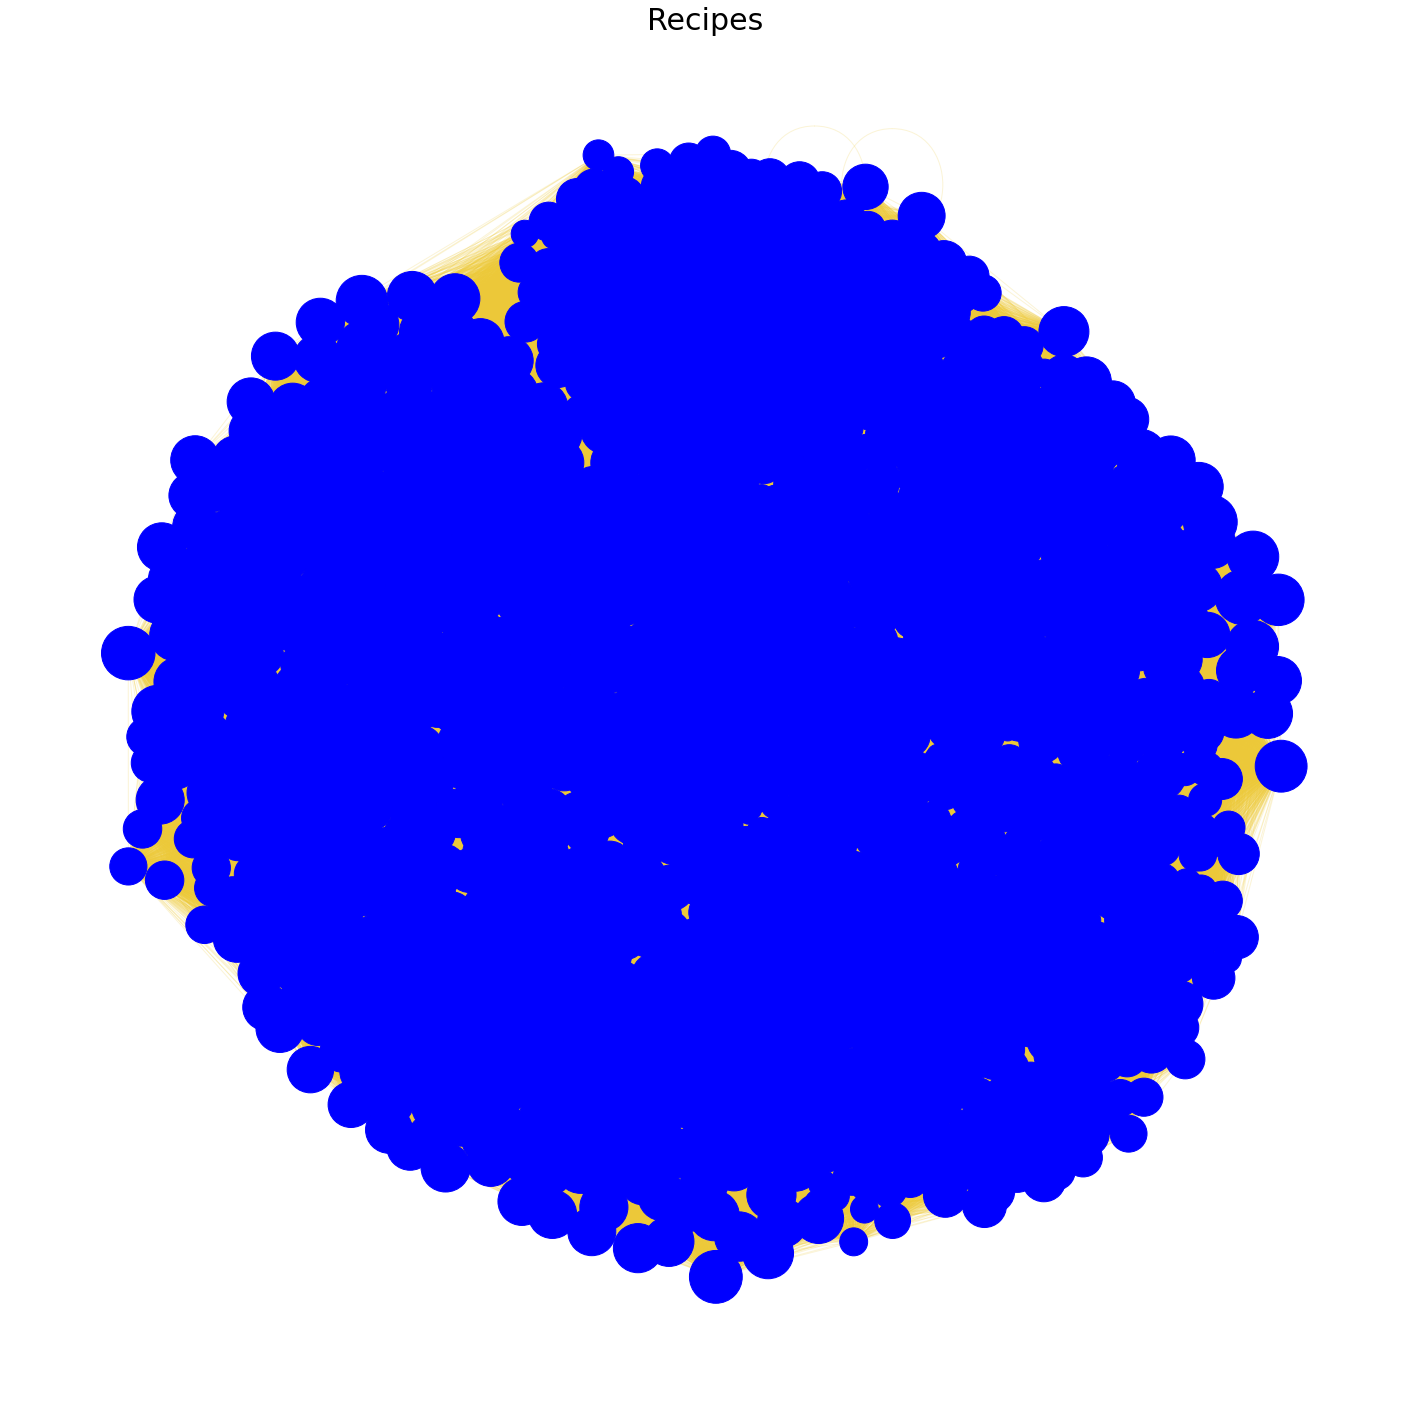

In [27]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from itertools import count
# Plot network using Force Atlas algorithm

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)



# Gets positions of the nodes 
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=2000)

# Node size dictionary according to degrees
d = dict(nx.degree(GCC))

# Create color mapping dictionary
#mapping = {"Marvel": 'red', "DC": 'black'}
#colors = [mapping[GCC_U.nodes[n]['universe']] for n in GCC_U.nodes()]



# Plot the Network 
plt.figure(3,figsize=(25,25)) 
nc = nx.draw_networkx_nodes(GCC, 
                       positions, 
                       node_size=[v * 2 for v in d.values()], 
                       #node_size = 2,
                       label=True,  
                       node_color='blue',
                       #cmap=plt.cm.plasma_r, 
                       )

ec = nx.draw_networkx_edges(GCC, 
                            positions, 
                            edge_color="#ECC836", 
                            alpha=0.2)

plt.axis('off')
plt.title('Recipes', size = 30)
plt.show()